# 02b - Training Results

## I. Preliminaries

Import the libraries and functions for TODO.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse, Patch
from collections import Counter
import seaborn as sns
import torch
import yaml
import pickle

from metaboDGD.src import model
from metaboDGD.util import train
from metaboDGD.src.latent import RepresentationLayer
plt.rcParams["font.family"] = 'Arial'

In [2]:
f = open('outputs/results.pkl', 'rb')
results = pickle.load(f)
f.close()

np_normal_lbls = results['np_normal_lbls']
np_normal_log = results['np_normal_log']
cohorts_normal = results['cohorts_normal']

np_tumor_lbls = results['np_tumor_lbls']
np_tumor_log = results['np_tumor_log']
cohorts_tumor = results['cohorts_tumor']

np_raw_normal_lbls = results['np_raw_normal_lbls']
np_raw_tumor_lbls = results['np_raw_tumor_lbls']

history = results['history']
cm = results['cm']

In [3]:
config_model = yaml.safe_load(open('model.yaml', 'r'))
config_train = yaml.safe_load(open('train.yaml', 'r'))

dgd_final = model.MetaboDGD(**config_model)
dgd_final.dec.load_state_dict(torch.load('torch_outputs/torch_outputs_dec.pt'))
dgd_final.gmm.load_state_dict(torch.load('torch_outputs/torch_outputs_gmm.pt'))

train_rep_final = RepresentationLayer(values=torch.zeros(size=(np_normal_log.shape[0], dgd_final.gmm.dim)))
train_rep_final.load_state_dict(torch.load('torch_outputs/torch_outputs_train_rep.pt'))

<All keys matched successfully>

In [4]:
f = open('outputs/tumor_results.pkl', 'rb')
tumor_results = pickle.load(f)
f.close()

tumor_rep_final = tumor_results['tumor_rep_final']
dec_out_final   = tumor_results['dec_out_final']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment



le = LabelEncoder()
true_labels = le.fit_transform(np_raw_normal_lbls)

clustering  = torch.exp(dgd_final.gmm.get_log_prob_comp(train_rep_final.z.detach()))
pred_labels = torch.max(clustering, dim=-1).indices.cpu().detach()

cm_test = confusion_matrix(true_labels, pred_labels)
idxs = linear_sum_assignment(-cm_test + np.max(cm_test))
normal_idxs = np.copy(idxs[1])
cm2 = cm_test[:, idxs[1]]

acc = np.trace(cm2) / np.sum(cm2)
acc

(40, 40)
(31,)
(36,)


np.float64(0.7922330097087379)

## II. Training Curves

Get the training and validation loss, and clustering accuracy curves after training the model.

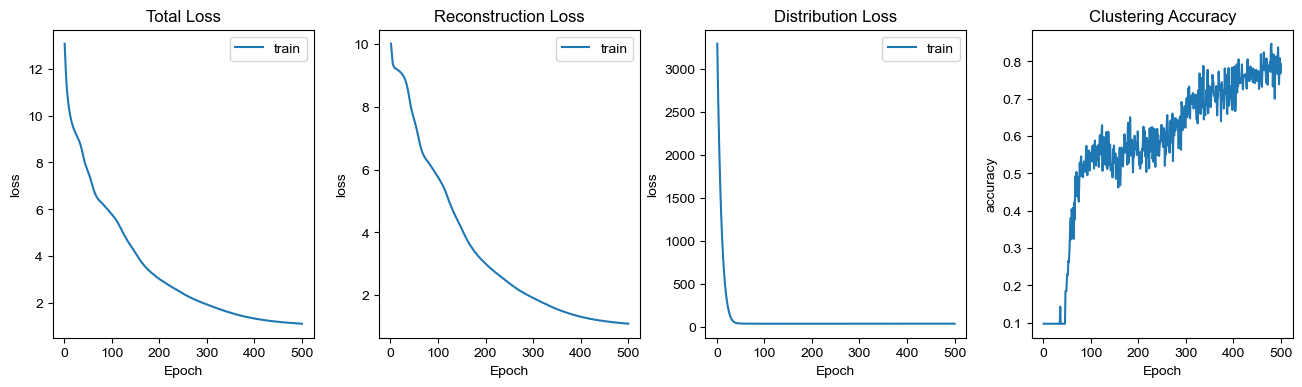

AttributeError: 'str' object has no attribute 'size'

<Figure size 640x480 with 0 Axes>

In [6]:
train.get_history_plot(history, inc_gmm_acc=True, with_val_plot=False)

In [41]:
f = open('outputs/history_results.pkl', 'rb')
history_results = pickle.load(f)
f.close()

In [45]:
history_results[h].head(3)

,train_loss,val_loss,train_recon_loss,val_recon_loss,train_dist_loss,val_dist_loss,cluster_acc,epoch
0,11.366290,10.993922,9.713117,9.489694,1780.963655,1620.504920,0.097525,1
1,11.056556,10.679591,9.634279,9.382802,1532.219569,1397.030612,0.097525,2
2,10.745436,10.387230,9.518164,9.266747,1322.140302,1207.097303,0.097525,3


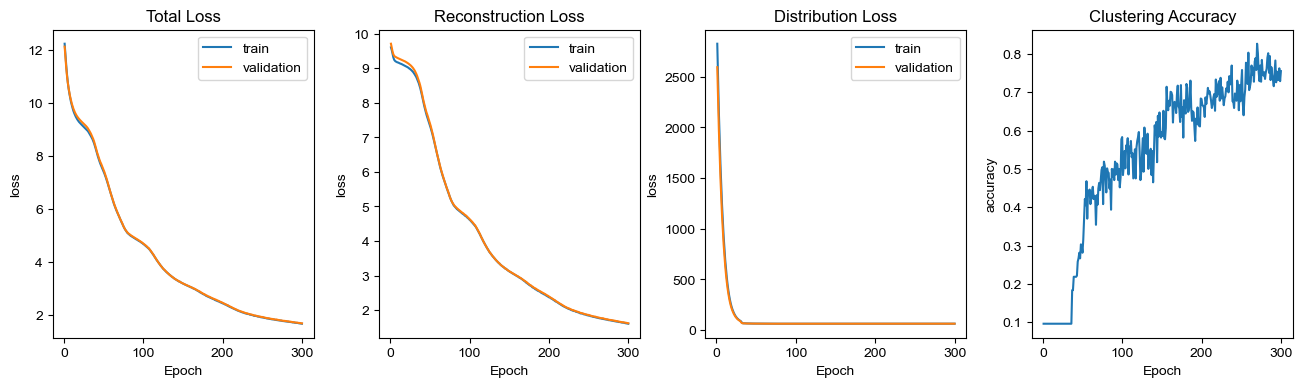

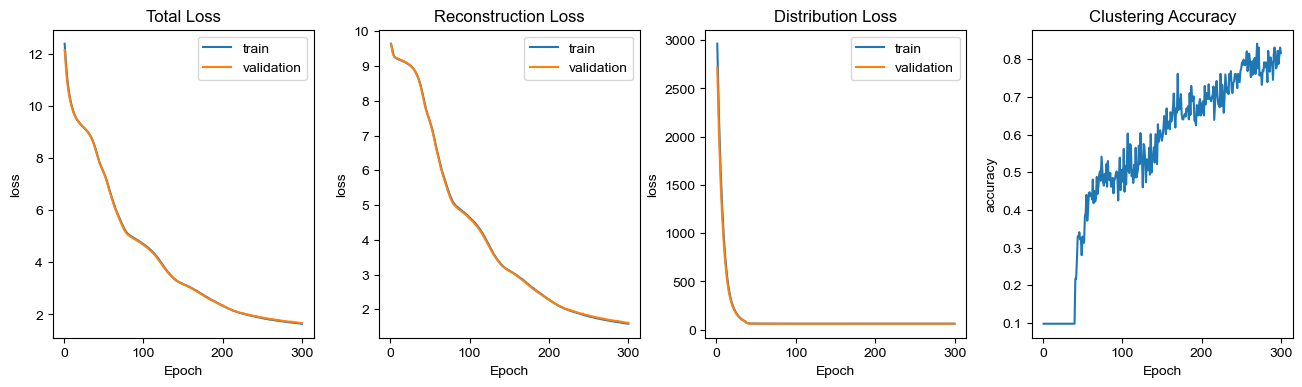

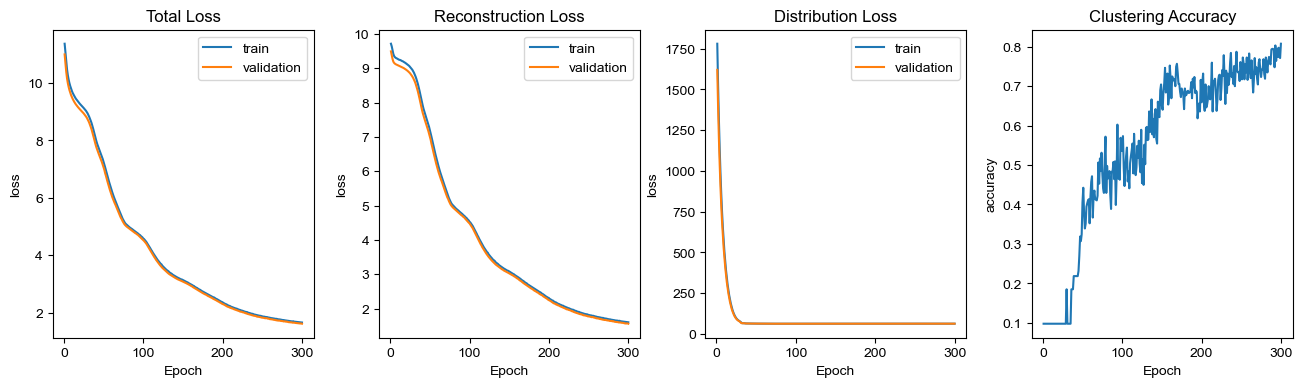

In [44]:
for h in history_results:
    train.get_history_plot(history_results[h], inc_gmm_acc=True, with_val_plot=True)

## III. Normal Representations Matrix

C:\Users\Alfonso Miguel Cruz\AppData\Local\Temp\ipykernel_15832\1515703755.py:21: RuntimeWarning: invalid value encountered in divide
  cm_norm = np.round(np.nan_to_num(cm_copy / np.sum(cm_copy, axis=0) * 100), decimals=1)


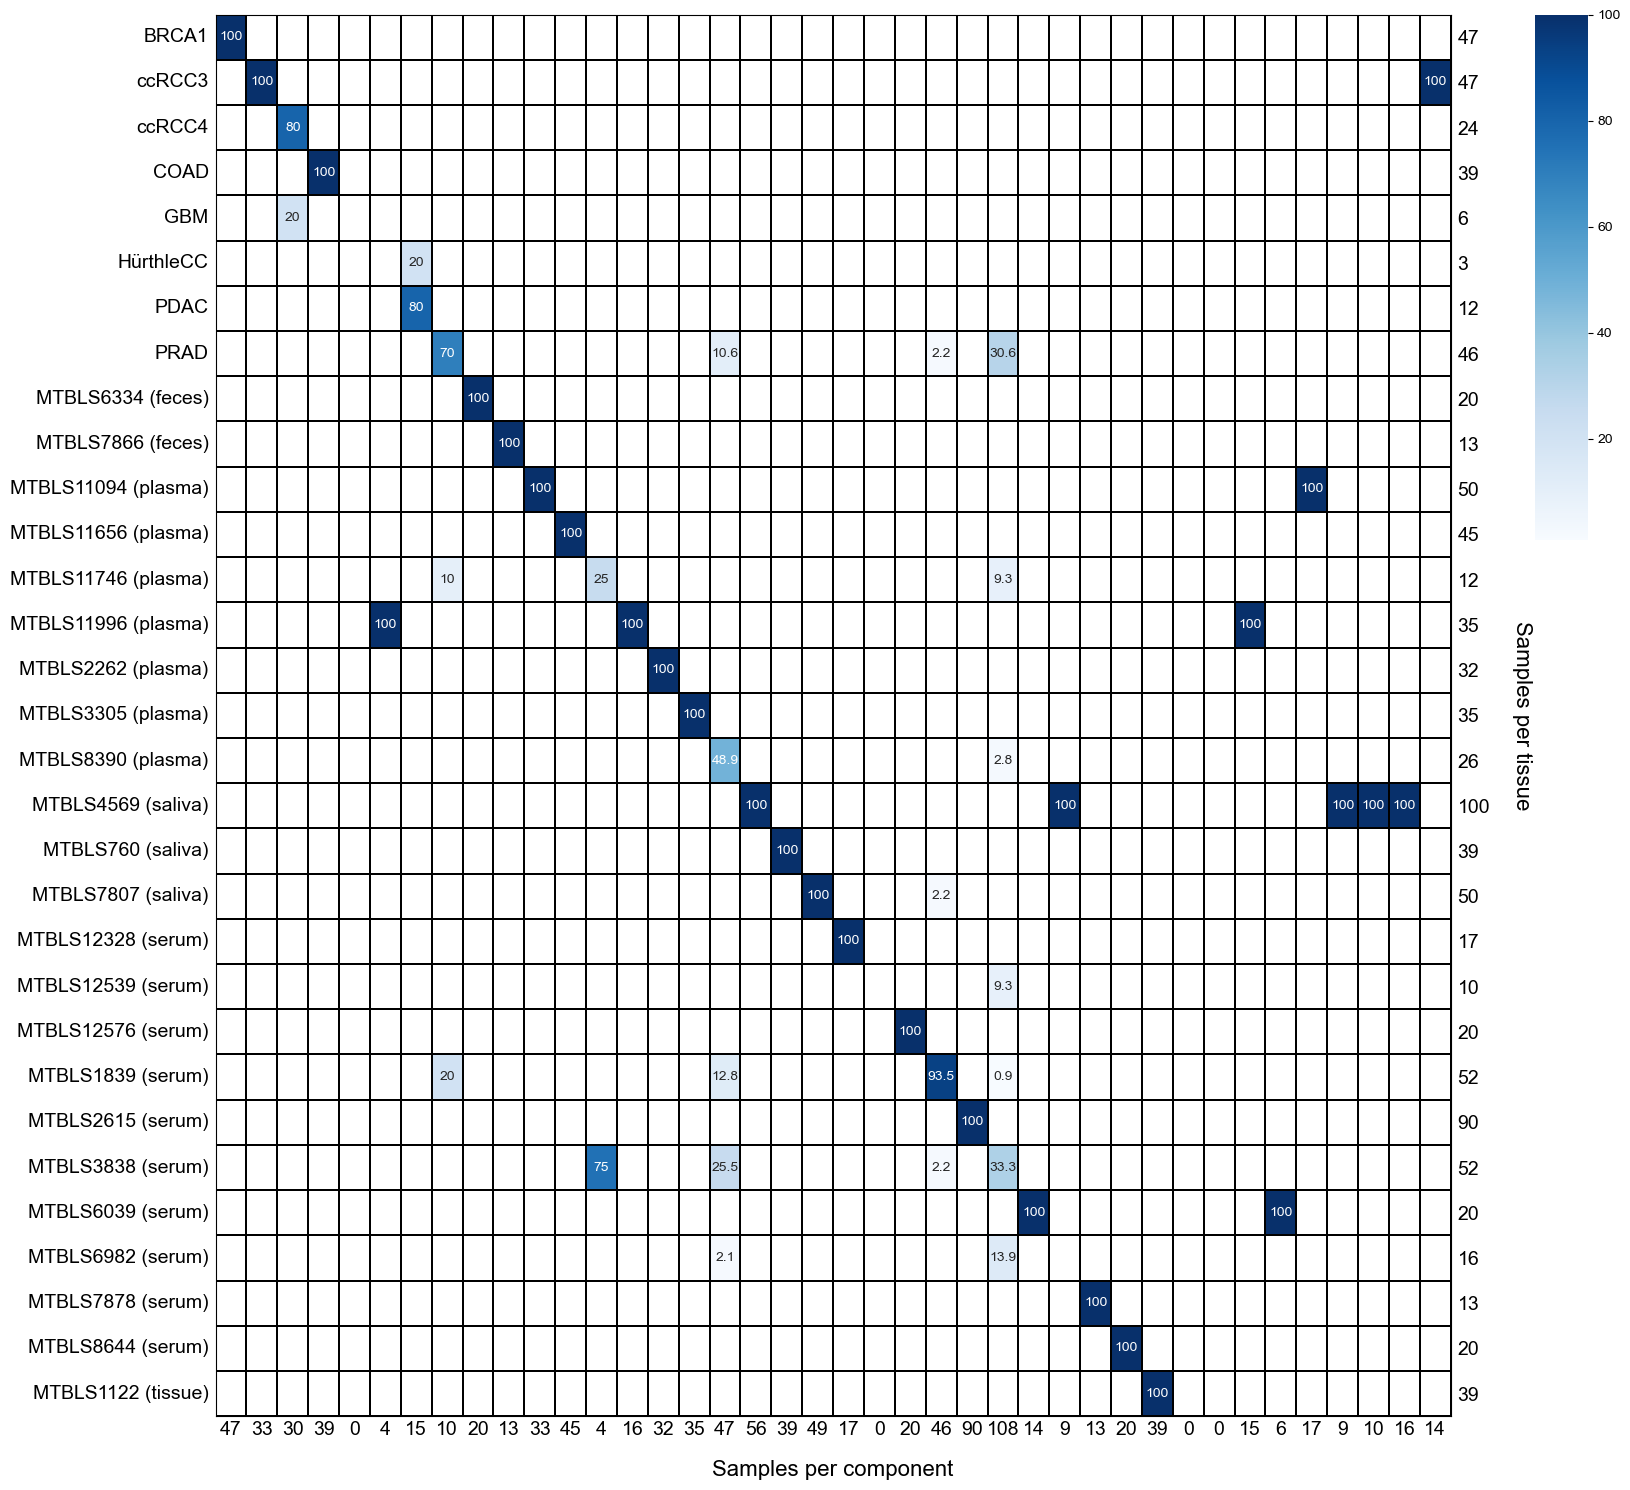

In [7]:
class_lbls = []
for c in cohorts_normal:
    if c == 'CCRCC3':
        class_lbls.append('ccRCC3')
    elif c == 'CCRCC4':
        class_lbls.append('ccRCC4')
    elif c == 'HurthleCC':
        class_lbls.append('HürthleCC')
    elif '_MTBLS' in c:
        temp = c.split('_')
        fin = temp[1] + f' ({temp[0]})'
        class_lbls.append(fin)
    else:
        class_lbls.append(c)

    
cm_copy = np.copy(cm)
bool_mask = ~np.all(cm_copy == 0, axis=1)
cm_copy = cm_copy[bool_mask]

cm_norm = np.round(np.nan_to_num(cm_copy / np.sum(cm_copy, axis=0) * 100), decimals=1)
# np.sum(cm, axis=0)

# class_lbls = [c for c in cohorts_normal]
sample_num_lbls = [len(cohorts_normal[c]['sample_list']) for c in cohorts_normal]

zr_mask = np.where(cm_norm > 0, False, True)

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(cm_norm, cmap='Blues',
            annot=True,
            fmt='g',
            xticklabels=np.sum(cm_copy, axis=0),
            yticklabels=class_lbls,
            linewidths=0.1,
            mask=zr_mask,
            linecolor='black',
            ax=ax,
            cbar_kws={
                'pad': 0.15,
                'shrink': 0.375,
                'aspect': 10,
                'anchor': (-0.85, 1.0)
            })

ax_y = ax.twinx()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.tick_params(axis='both', length=0)

ax_y.set_yticks(ax.get_yticks())
ax_y.set_ylim(ax.get_ylim())
ax_y.set_yticklabels(sample_num_lbls, fontsize=14)
ax_y.tick_params(axis='y', length=0)

ax.set_xlabel('Samples per component', fontsize=16, labelpad=15)
ax_y.set_ylabel('Samples per tissue' , fontsize=16, labelpad=30, rotation=270)

ax.tick_params(  axis='y', direction='out', pad=5)
ax_y.tick_params(axis='y', direction='out', pad=5)

# ax.set_title('Gaussian Components', pad=15, fontsize=14)

# fig.subplots_adjust(bottom=0.5)
plt.tight_layout()
plt.savefig('figures/gmm_clustering_result_normal.png', bbox_inches='tight')

## III. PCA Plots

In [8]:
pca_labels = {
        "BRCA1": 'Breast (BRCA1)',
        "CCRCC3": 'Kidney (ccRCC3)',
        "CCRCC4": 'Kidney (ccRCC4)',
        "COAD": 'Colon (COAD)',
        "GBM": 'Brain (GBM)',
        "HurthleCC": 'Thyroid (HurthleCC)',
        "PDAC": 'Pancreas (PDAC)',
        "PRAD": 'Prostate (PRAD)',
        "feces_MTBLS6334": 'Feces',
        "feces_MTBLS7866": 'Feces',
        "plasma_MTBLS11094": 'Plasma',
        "plasma_MTBLS11746": 'Plasma',
        "plasma_MTBLS11656": 'Plasma',
        "plasma_MTBLS3305":  'Plasma',
        "plasma_MTBLS8390":  'Plasma',
        "plasma_MTBLS1183":  'Plasma',
        "plasma_MTBLS2262":  'Plasma',
        "plasma_MTBLS11996": 'Plasma',
        "saliva_MTBLS4569": 'Saliva',
        "saliva_MTBLS7807": 'Saliva',
        "saliva_MTBLS760":  'Saliva',
        "serum_MTBLS12539": 'Serum',
        "serum_MTBLS12576": 'Serum',
        "serum_MTBLS8644":  'Serum',
        "serum_MTBLS7878":  'Serum',
        "serum_MTBLS6982":  'Serum',
        "serum_MTBLS2615":  'Serum',
        "serum_MTBLS1839":  'Serum',
        "serum_MTBLS12328": 'Serum',
        "serum_MTBLS6039":  'Serum',
        "serum_MTBLS3838":  'Serum',
        "tissue_MTBLS1122": 'Tissue'
    }

pca_markers = {
        "BRCA1": 'D',
        "CCRCC3": 'o',
        "CCRCC4": 'o',
        "COAD": '^',
        "GBM": 'D',
        "HurthleCC": 'o',
        "PDAC": 'D',
        "PRAD": 'D',
        "feces_MTBLS6334":  'o',
        "feces_MTBLS7866":  'o',
        "plasma_MTBLS11094":'o',
        "plasma_MTBLS11746":'s',
        "plasma_MTBLS11656":'o',
        "plasma_MTBLS3305": 'o',
        "plasma_MTBLS8390": 'o',
        "plasma_MTBLS1183": 'o',
        "plasma_MTBLS2262": 'o',
        "plasma_MTBLS11996":'o',
        "saliva_MTBLS4569": 'o',
        "saliva_MTBLS7807": 'o',
        "saliva_MTBLS760":  'o',
        "serum_MTBLS12539": 'o',
        "serum_MTBLS12576": 'o',
        "serum_MTBLS8644":  'o',
        "serum_MTBLS7878":  'o',
        "serum_MTBLS6982":  's',
        "serum_MTBLS2615":  'o',
        "serum_MTBLS1839":  'o',
        "serum_MTBLS12328": 'o',
        "serum_MTBLS6039":  'o',
        "serum_MTBLS3838":  'o',
        "tissue_MTBLS1122": 'D',
    }


handles_analytical_platforms = [
    plt.Line2D([],[], color='black', marker='^', linestyle='None', label='CE-TOFMS'),
    plt.Line2D([],[], color='black', marker='s', linestyle='None', label='GC-MS'),
    plt.Line2D([],[], color='black', marker='o', linestyle='None', label='LC-MS'),
    plt.Line2D([],[], color='black', marker='D', linestyle='None', label='LC-MS and GC-MS'),
]

handles_biospecimen = [
    Patch(color='C0', label='Tissue (Breast)'),
    Patch(color='C1', label='Tissue (Kidney 3)'),
    Patch(color='C2', label='Tissue (Kidney 4)'),
    Patch(color='C3', label='Tissue (Colon)'),
    Patch(color='C4', label='Tissue (Brain)'),
    Patch(color='C5', label='Tissue (Thyroid)'),
    Patch(color='C6', label='Tissue (Pancreas)'),
    Patch(color='C7', label='Tissue (Prostate)'),
    Patch(color='#17104B', label='Feces'),
    Patch(color='#FF6666', label='Plasma'),
    Patch(color='#4BDEFF', label='Saliva'),
    Patch(color='#FFD000', label='Serum'),
    # Patch(color='#0FE283', label='Tissue (Colon)'),
    # Patch(color='#000000', label='GMM Means'),
]


colors = {
    
}

### Normal Representations in Latent Space

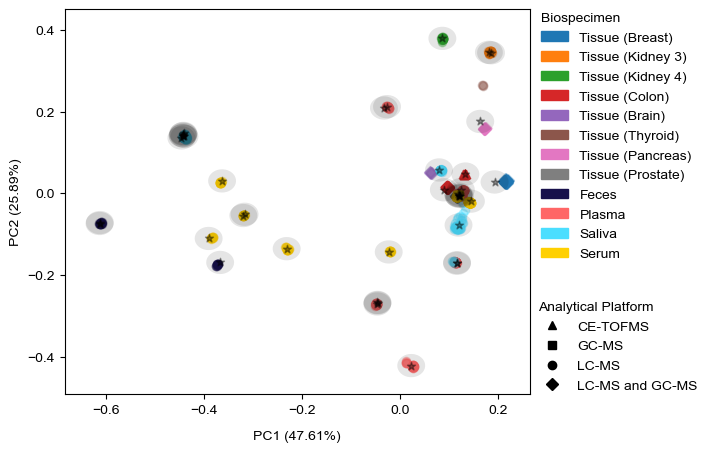

In [9]:
pca_counter = Counter(np_raw_normal_lbls)
means_and_reps = np.vstack((train_rep_final.z.detach().numpy(),dgd_final.gmm.means.detach().numpy()))
# means_and_reps = np.vstack(train_rep_final.z.detach().numpy())

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(means_and_reps)

fig, ax = plt.subplots(figsize=(6,5))

i = 0
j = 0
for c in cohorts_normal:
    k = pca_counter[c]
    j += k
    if ('feces' not in c) and ('plasma' not in c) and ('saliva' not in c) and ('serum' not in c) and ('tissue' not in c):
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c])
    elif 'feces' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='#17104B')
    elif 'plasma' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c="#FF6666")
    elif 'saliva' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c="#4BDEFF")
    elif 'serum' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c="#FFD000")
    elif 'tissue' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='C3')
    i = j


ax.scatter(pca_fit[1030:,0], pca_fit[1030:,1], label='GMM Means', c='black', alpha=0.4, marker='*')
# ax.set_title('Normal Representations in Latent Space')

P = pca.components_
for x in range(0, dgd_final.gmm.n_comp):
    cov_2d = np.diag(torch.exp(dgd_final.gmm.log_var).detach().numpy()[x])
    # print(cov_2d)
    mean_2d = P @ (dgd_final.gmm.means.detach().numpy()[x] - pca.mean_)
    # mean_2d = pca_fit[175+x]
    cov_2d_projected = P @ cov_2d @ P.T

    vals, vecs = np.linalg.eigh(cov_2d_projected)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    
    std = 2.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse_2 = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                        facecolor='black', alpha=0.1
                       )
    ax.add_patch(ellipse_2)

    # std = 1.0
    # w, h = 2 * std * np.sqrt(vals)
    # ellipse = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
    #                   edgecolor='black', lw=1, alpha=0.0625, facecolor='none'
    #                  )
    # ax.add_patch(ellipse)


ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')


l1 = ax.legend(handles=handles_biospecimen,
               bbox_to_anchor=(1.375, 1.025),
               loc='upper right',
               fancybox=False,
               framealpha=0.0,
               title='Biospecimen',
               alignment='left'
               )
ax.add_artist(l1)

l2 = ax.legend(handles=handles_analytical_platforms,
               bbox_to_anchor=(1.3875, 0.275),
               loc='upper right',
               fancybox=False,
               framealpha=0.0,
               title='Analytical Platform',
               alignment='left')

plt.savefig('figures/pca_latent_rep_normal.png', bbox_inches='tight')

### Tumor Representations and Means in Latent Space

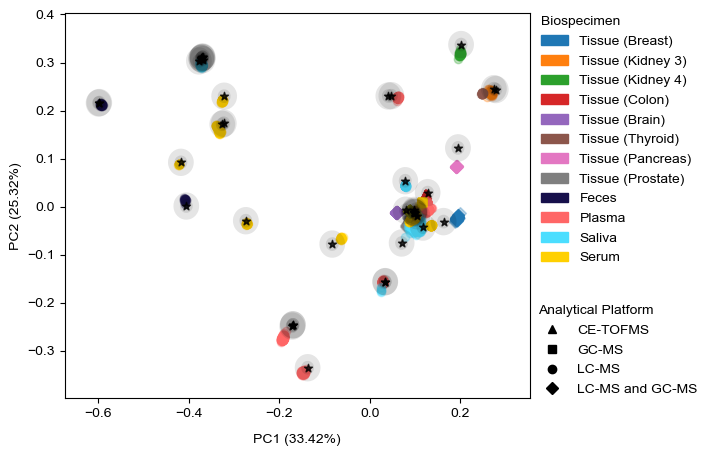

In [10]:
from collections import Counter

pca_counter = Counter(np_raw_tumor_lbls)
means_and_tumor_reps = np.vstack((tumor_rep_final, dgd_final.gmm.means.detach().numpy()))

pca_tumor = PCA(n_components=2)
pca_fit = pca_tumor.fit_transform(means_and_tumor_reps)

fig, ax = plt.subplots(figsize=(6,5))

i = 0
j = 0
for c in cohorts_tumor:
    k = pca_counter[c]
    j += k

    if ('plasma' not in c) and ('serum' not in c) and ('feces' not in c) and ('saliva' not in c):
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c])
    elif 'feces' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='#17104B')
    elif 'plasma' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='#FF6666')
    elif 'saliva' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='#4BDEFF')
    elif 'serum' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='#FFD000')
    elif 'tissue' in c:
        ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=pca_labels[c], alpha=0.3, marker=pca_markers[c], c='C3')
    i = j


ax.scatter(pca_fit[2167:,0], pca_fit[2167:,1], label='GMM Means', c='black', alpha=0.8, marker='*')

P = pca_tumor.components_
for x in range(0, dgd_final.gmm.n_comp):
    cov_2d = np.diag(torch.exp(dgd_final.gmm.log_var).detach().numpy()[x])
    # print(cov_2d)
    mean_2d = P @ (dgd_final.gmm.means.detach().numpy()[x] - pca_tumor.mean_)
    # mean_2d = pca_fit[175+x]
    cov_2d_projected = P @ cov_2d @ P.T

    vals, vecs = np.linalg.eigh(cov_2d_projected)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    
    std = 1.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                      facecolor='black', alpha=0.1)
    ax.add_patch(ellipse)

    std = 2.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse_2 = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                      facecolor='black', alpha=0.1)
    ax.add_patch(ellipse_2)


ax.set_xlabel(f'PC1 ({(pca_tumor.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca_tumor.explained_variance_ratio_[1] * 100):.2f}%)')


l1 = ax.legend(handles=handles_biospecimen,
               bbox_to_anchor=(1.375, 1.025),
               loc='upper right',
               fancybox=False,
               framealpha=0.0,
               title='Biospecimen',
               alignment='left'
               )
ax.add_artist(l1)

l2 = ax.legend(handles=handles_analytical_platforms,
               bbox_to_anchor=(1.3875, 0.275),
               loc='upper right',
               fancybox=False,
               framealpha=0.0,
               title='Analytical Platform',
               alignment='left')

plt.savefig('figures/pca_latent_rep_disease.png', bbox_inches='tight')

## IV. Diseased Representations Matrix

In [11]:
train_rep_final.z.shape

torch.Size([1030, 10])

In [12]:
normal_idxs

array([22, 38,  0, 26, 10,  2, 28, 19, 34, 17,  4,  8, 21, 18, 20, 14, 31,
       12,  6,  1, 30,  7,  5, 13, 16, 11, 33,  9,  3, 24, 25, 15, 23, 27,
       29, 32, 35, 36, 37, 39])

In [16]:
pred_labels.shape

torch.Size([1030])

In [18]:
len(normal_idxs)

40

In [30]:
le = LabelEncoder()
true_labels = le.fit_transform(np_raw_tumor_lbls)

clustering  = torch.exp(dgd_final.gmm.get_log_prob_comp(torch.Tensor(tumor_rep_final).detach()))
pred_labels = torch.max(clustering, dim=-1).indices.cpu().detach()
cm_test = confusion_matrix(true_labels, pred_labels, labels=np.r_[0:40])
print(cm_test.shape)
# idxs = linear_sum_assignment(-cm_test + np.max(cm_test))
# cm2 = cm_test[:, idxs[1]]

cm_disease = cm_test[:, normal_idxs]

# acc = np.trace(cm2) / np.sum(cm2)
# acc

(40, 40)


C:\Users\Alfonso Miguel Cruz\AppData\Local\Temp\ipykernel_15832\645384224.py:21: RuntimeWarning: invalid value encountered in divide
  cm_norm = np.round(np.nan_to_num(cm_copy / np.sum(cm_copy, axis=0) * 100), decimals=1)


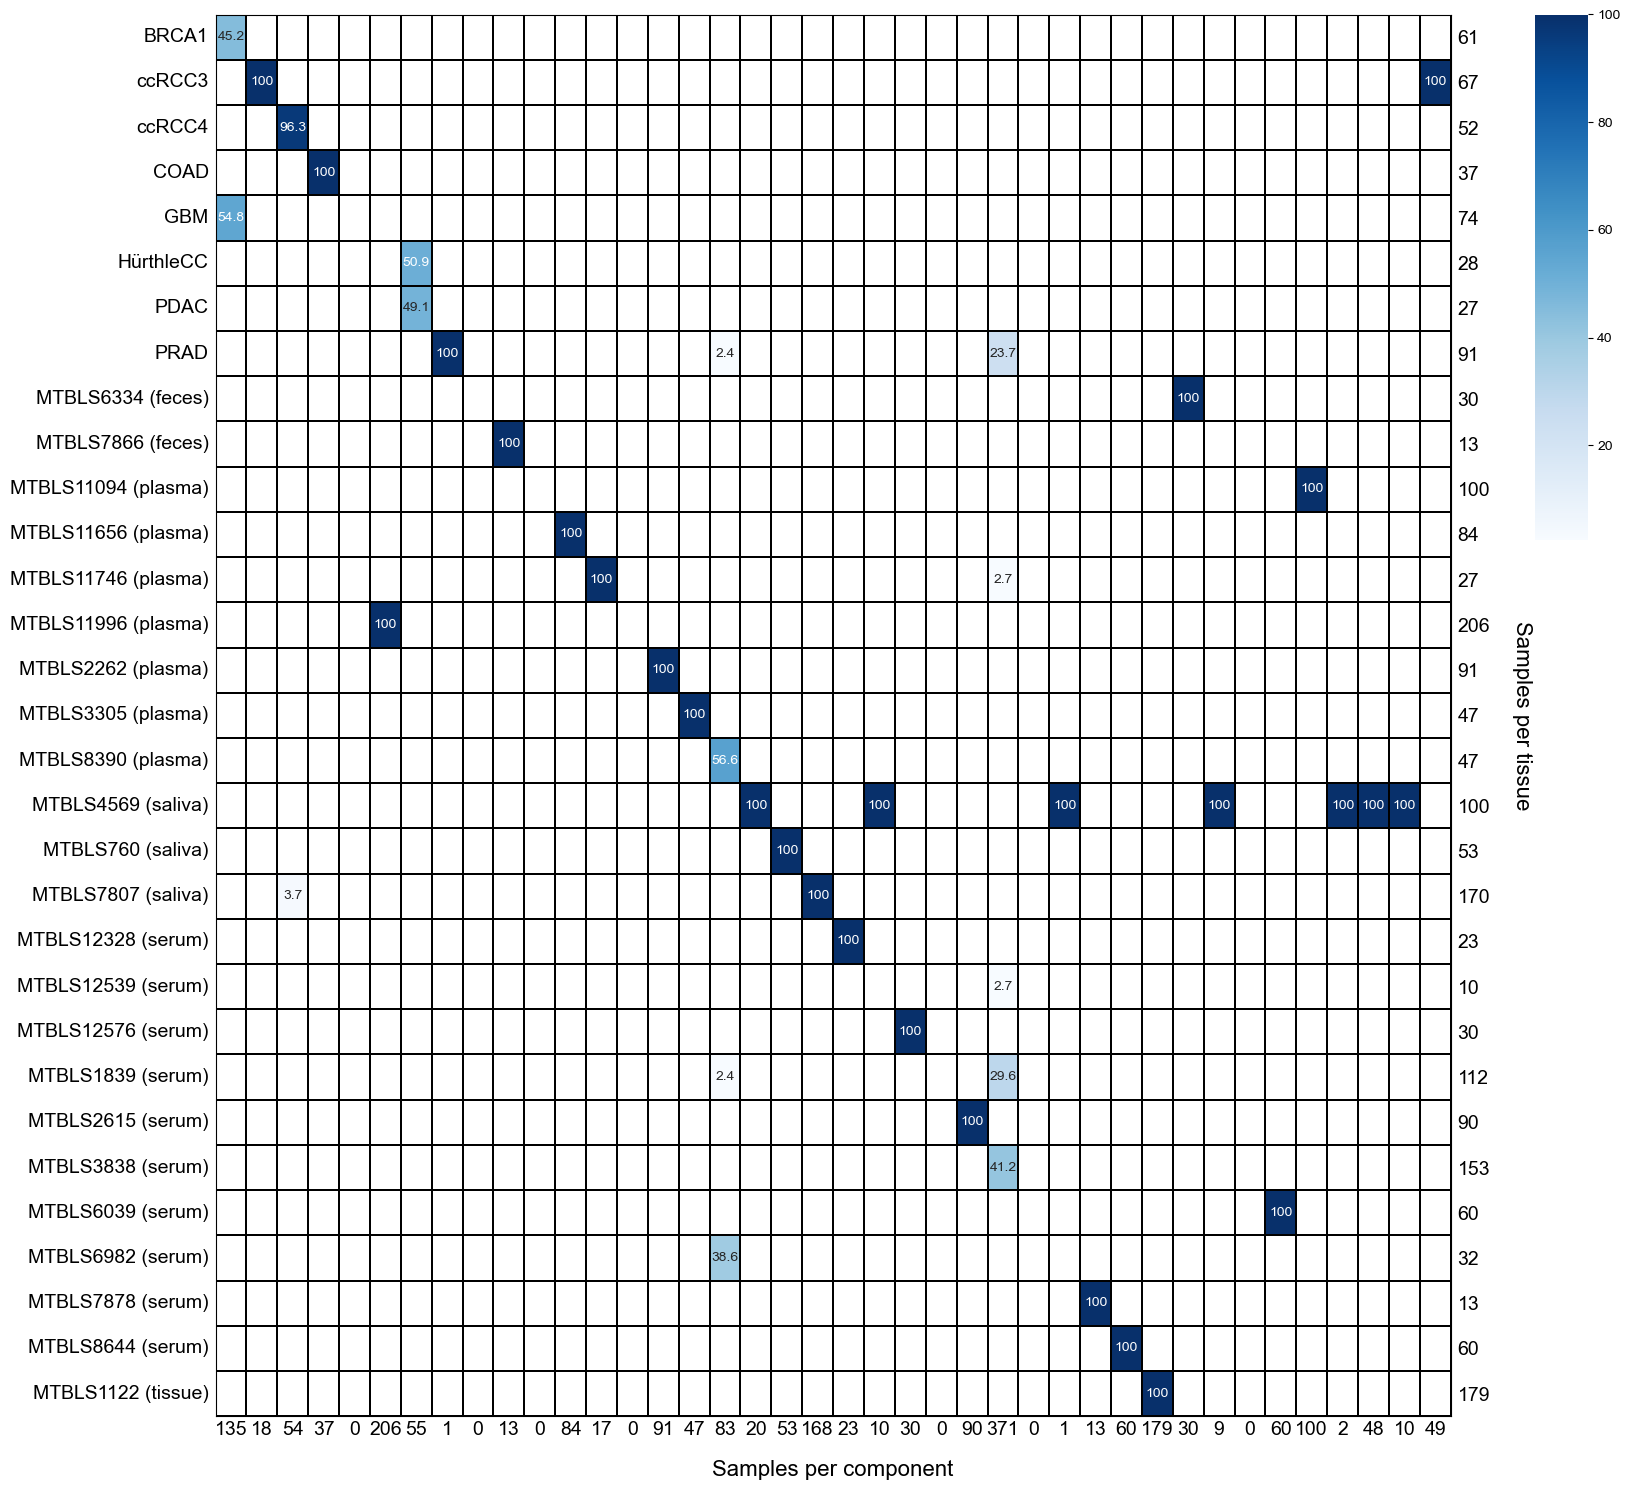

In [31]:
class_lbls = []
for c in cohorts_normal:
    if c == 'CCRCC3':
        class_lbls.append('ccRCC3')
    elif c == 'CCRCC4':
        class_lbls.append('ccRCC4')
    elif c == 'HurthleCC':
        class_lbls.append('HürthleCC')
    elif '_MTBLS' in c:
        temp = c.split('_')
        fin = temp[1] + f' ({temp[0]})'
        class_lbls.append(fin)
    else:
        class_lbls.append(c)

    
cm_copy = np.copy(cm_disease)
bool_mask = ~np.all(cm_copy == 0, axis=1)
cm_copy = cm_copy[bool_mask]

cm_norm = np.round(np.nan_to_num(cm_copy / np.sum(cm_copy, axis=0) * 100), decimals=1)
# np.sum(cm, axis=0)

# class_lbls = [c for c in cohorts_normal]
sample_num_lbls = [len(cohorts_tumor[c]['sample_list']) for c in cohorts_tumor]

zr_mask = np.where(cm_norm > 0, False, True)

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(cm_norm, cmap='Blues',
            annot=True,
            fmt='g',
            xticklabels=np.sum(cm_copy, axis=0),
            yticklabels=class_lbls,
            linewidths=0.1,
            mask=zr_mask,
            linecolor='black',
            ax=ax,
            cbar_kws={
                'pad': 0.15,
                'shrink': 0.375,
                'aspect': 10,
                'anchor': (-0.85, 1.0)
            })

ax_y = ax.twinx()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.tick_params(axis='both', length=0)

ax_y.set_yticks(ax.get_yticks())
ax_y.set_ylim(ax.get_ylim())
ax_y.set_yticklabels(sample_num_lbls, fontsize=14)
ax_y.tick_params(axis='y', length=0)

ax.set_xlabel('Samples per component', fontsize=16, labelpad=15)
ax_y.set_ylabel('Samples per tissue' , fontsize=16, labelpad=30, rotation=270)

ax.tick_params(  axis='y', direction='out', pad=5)
ax_y.tick_params(axis='y', direction='out', pad=5)

# ax.set_title('Gaussian Components', pad=15, fontsize=14)

# fig.subplots_adjust(bottom=0.5)
plt.tight_layout()
plt.savefig('figures/gmm_clustering_result_disease.png', bbox_inches='tight')

???

In [36]:
import pandas as pd
hgs_df = pd.read_csv('gcp_0.50_masterlist.csv')

0.768869773
393376979.9


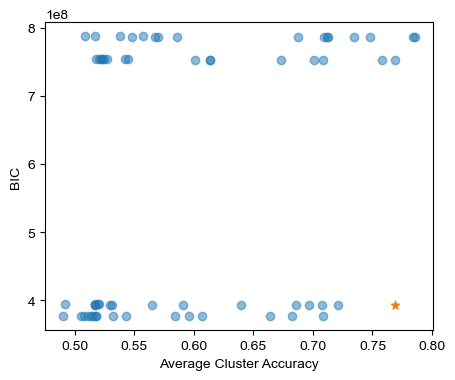

In [52]:
fig, ax = plt.subplots(figsize=(5,4))
for i in range(0,64):
    if i != 15:
        ax.scatter(x=hgs_df.iloc[i]['cluster_accuracy'], y=hgs_df.iloc[i]['bic'], alpha=0.5, c='C0')
    else:
        ax.scatter(x=hgs_df.iloc[i]['cluster_accuracy'], y=hgs_df.iloc[i]['bic'], c='C1', marker='*')
        print(hgs_df.iloc[i]['cluster_accuracy'])
        print(hgs_df.iloc[i]['bic'])

ax.set_xlabel('Average Cluster Accuracy')
ax.set_ylabel('BIC')

plt.savefig('figures/grid_search_best_parameters.png', bbox_inches='tight')